<a href="https://colab.research.google.com/github/riponazad/OOD_Detection/blob/main/Softmax_score_OOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(trainset)
print(validationset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        #x = self.sm(x)
        return x

In [ ]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

We're using => cuda:0
CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)


In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([64, 1, 28, 28])

In [ ]:
len(trainset)

60000

Ankle Boot


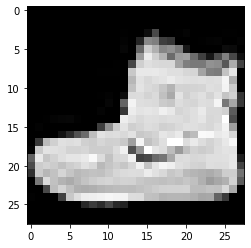

In [ ]:
image, label = next(iter(trainset))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

Shirt
torch.Size([64, 1, 28, 28]) torch.Size([64])


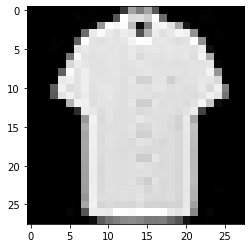

In [ ]:
image, label = next(iter(train_loader))
plt.imshow(image[10].squeeze(), cmap="gray")
print(output_label(label[10]))
print(image.size(), label.size())

In [ ]:
def Accuracy(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
print("Begin training.")
for e in tqdm(range(5)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        #print(y_train_pred)
        #y_train_pred = y_train_pred.argmax(1)
        #print(y_train_pred.size(), y_train_batch.size())
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.5f}')

Begin training.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch 00: | Train Loss: 0.42998 | Train Acc: 85.03305



Epoch 01: | Train Loss: 0.29543 | Train Acc: 89.51812



Epoch 02: | Train Loss: 0.25953 | Train Acc: 90.80597



Epoch 03: | Train Loss: 0.23409 | Train Acc: 91.70362



Epoch 04: | Train Loss: 0.21524 | Train Acc: 92.30490



In [ ]:
#TESTING
y_pred_list = []
y_true_list = []
correct_softmax_scores = []
incorrect_softmax_scores = []
correct_results_sum = 0
num_samples = 0
threshold = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _h, y_pred_tag = torch.max(y_test_pred, dim = 1)
        #print(_h, y_pred_tag)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        correct_results_sum += (y_pred_tag == y_batch).sum()
        threshold += ((y_pred_tag == y_batch)*_h).sum()
        #threshold += _h.sum()
        num_samples += len(y_batch)
        for i in range(len(_h)):
          if y_pred_tag[i]==y_batch[i]:
            correct_softmax_scores.append(_h[i].cpu().numpy())
          else:
            incorrect_softmax_scores.append(_h[i].cpu().numpy())
acc = correct_results_sum.float()/num_samples
acc = torch.round(acc * 100)
print(f'Accuracy: {acc}')
threshold = threshold/correct_results_sum
print(f'avg threshold: {threshold}')
print(len(correct_softmax_scores), len(incorrect_softmax_scores))


Accuracy: 90.0
avg threshold: -0.06984458118677139
9039 961


In [ ]:
y_pred = []
y_true = []
for i in range(len(y_true_list)):
    for j in range(len(y_true_list[i])):
        y_pred.append(y_pred_list[i][j])
        y_true.append(y_true_list[i][j])
#len(y_true), len(y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.80      0.93      0.86      1000
           3       0.89      0.92      0.91      1000
           4       0.84      0.83      0.84      1000
           5       0.96      0.99      0.98      1000
           6       0.78      0.68      0.73      1000
           7       0.93      0.97      0.95      1000
           8       0.96      0.99      0.98      1000
           9       0.99      0.92      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
# Download and load the OOD data
oodset = datasets.MNIST('./data', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=64, shuffle=True)
print(oodset)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
#Detecting OOD using log_softmax avg as threshold
ood_softmax_scores = []
ood_softmax_scores1 = []
ood_val = []
ood_sum = 0
num_samples = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _h, y_pred_tag = torch.max(y_test_pred, dim = 1)
        #print(_h, y_pred_tag)
        ood_sum += (_h < threshold).sum()
        num_samples += len(y_batch)
        for i in range(len(_h)):
          ood_softmax_scores.append(_h[i].cpu().numpy())
          ood_softmax_scores1.append(_h[i].cpu().numpy())
          ood_val.append(0)
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


number of correct ood detection: 5018
accuracy: 0.501800000667572


In [ ]:
#Detecting OOD using log_softmax avg as threshold
ood_sum = 0
num_samples = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _h, y_pred_tag = torch.max(y_test_pred, dim = 1)
        #print(_h, y_pred_tag)
        ood_sum += (_h < threshold).sum()
        num_samples += len(y_batch)
        for i in range(len(_h)):
          ood_softmax_scores.append(_h[i].cpu().numpy())
          ood_val.append(1)
print(f'number of incorrect ood detection: {ood_sum}')
print(f'accuracy: {1-ood_sum/num_samples}')


number of incorrect ood detection: 2750
accuracy: 0.7250000238418579


In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.70


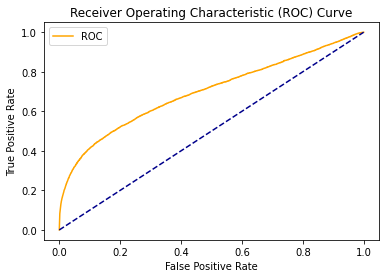

In [ ]:
auc = roc_auc_score(ood_val, ood_softmax_scores)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(ood_val, ood_softmax_scores)
plot_roc_curve(fpr, tpr)

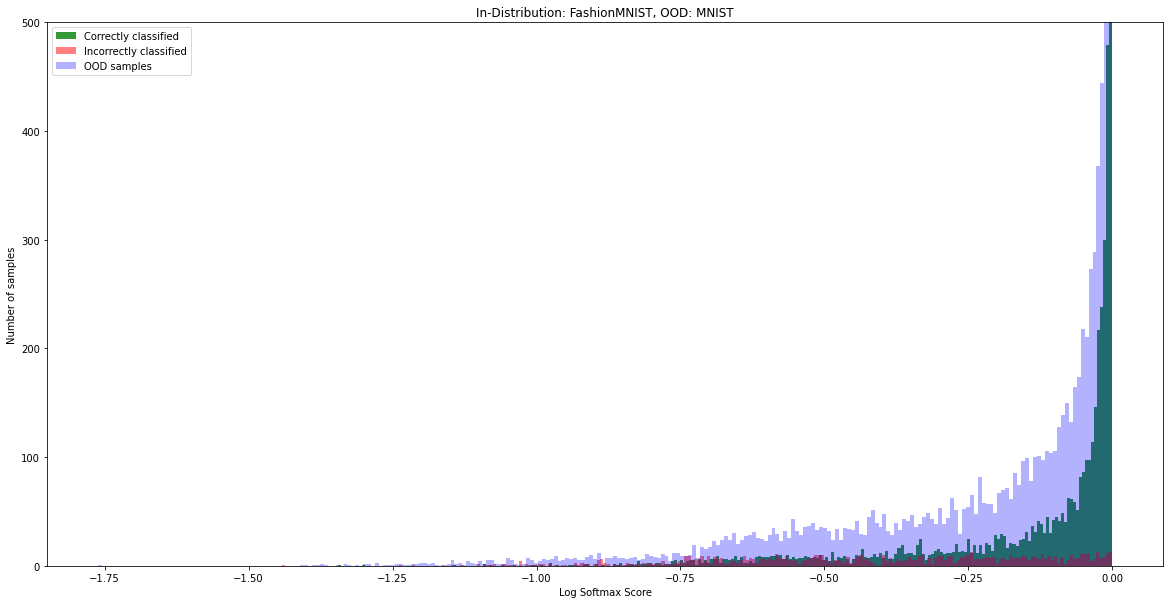

In [ ]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.hist(correct_softmax_scores, bins = 256, color='green', alpha = 0.8)
plt.hist(incorrect_softmax_scores, bins = 256, color='red', alpha = 0.5)
plt.hist(ood_softmax_scores1, bins = 256, color='blue', alpha = 0.3)
plt.ylim(0,500)
plt.xlabel('Log Softmax Score')
plt.ylabel('Number of samples')
plt.legend(['Correctly classified', 'Incorrectly classified', 'OOD samples'])
plt.title("In-Distribution: FashionMNIST, OOD: MNIST")
plt.show()

In [ ]:
# creating model,and defining optimizer and loss
model2 = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model2.to(device)
print(model2)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.NLLLoss()

We're using => cuda:0
CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)


In [ ]:
trainsetMNIST = datasets.MNIST('./data', download=True, train=True, transform=transform)
trainMNIST_loader = DataLoader(trainsetMNIST, batch_size=64, shuffle=True)
print(trainsetMNIST)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
print("Begin training.")
for e in tqdm(range(5)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    batch_num = 1
    model2.train()
    for X_train_batch, y_train_batch in tqdm(trainMNIST_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model2(X_train_batch)
        #print(y_train_pred)
        #y_train_pred = y_train_pred.argmax(1)
        #print(y_train_pred.size(), y_train_batch.size())
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(trainMNIST_loader):.5f} | Train Acc: {train_epoch_acc/len(trainMNIST_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.16777 | Train Acc: 95.10021



Epoch 01: | Train Loss: 0.07313 | Train Acc: 97.62154



Epoch 02: | Train Loss: 0.05798 | Train Acc: 98.11940



Epoch 03: | Train Loss: 0.04607 | Train Acc: 98.43177



Epoch 04: | Train Loss: 0.03911 | Train Acc: 98.65245



In [ ]:
#TESTING
y_pred_list = []
y_true_list = []
correct_softmax_scores = []
incorrect_softmax_scores = []
correct_results_sum = 0
num_samples = 0
threshold = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model2(x_batch)
        _h, y_pred_tag = torch.max(y_test_pred, dim = 1)
        #print(_h, y_pred_tag)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        correct_results_sum += (y_pred_tag == y_batch).sum()
        threshold += ((y_pred_tag == y_batch)*_h).sum()
        #threshold += _h.sum()
        num_samples += len(y_batch)
        for i in range(len(_h)):
          if y_pred_tag[i]==y_batch[i]:
            correct_softmax_scores.append(_h[i].cpu().numpy())
          else:
            incorrect_softmax_scores.append(_h[i].cpu().numpy())
acc = correct_results_sum.float()/num_samples
acc = torch.round(acc * 100)
print(f'Accuracy: {acc}')
threshold = threshold/correct_results_sum
print(f'avg threshold: {threshold}')
print(len(correct_softmax_scores), len(incorrect_softmax_scores))


Accuracy: 99.0
avg threshold: -0.006300047505646944
9877 123


In [ ]:
y_pred = []
y_true = []
for i in range(len(y_true_list)):
    for j in range(len(y_true_list[i])):
        y_pred.append(y_pred_list[i][j])
        y_true.append(y_true_list[i][j])
#len(y_true), len(y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       1.00      0.97      0.98       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
#Detecting OOD using log_softmax avg as threshold
ood_softmax_scores = []
ood_softmax_scores1 = []
ood_val = []
ood_sum = 0
num_samples = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model2(x_batch)
        _h, y_pred_tag = torch.max(y_test_pred, dim = 1)
        #print(_h, y_pred_tag)
        ood_sum += (_h < threshold).sum()
        num_samples += len(y_batch)
        for i in range(len(_h)):
          ood_softmax_scores.append(_h[i].cpu().numpy())
          ood_softmax_scores1.append(_h[i].cpu().numpy())
          ood_val.append(0)
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


number of correct ood detection: 8738
accuracy: 0.8737999796867371


In [ ]:
#Detecting OOD using log_softmax avg as threshold
ood_sum = 0
num_samples = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model2(x_batch)
        _h, y_pred_tag = torch.max(y_test_pred, dim = 1)
        #print(_h, y_pred_tag)
        ood_sum += (_h < threshold).sum()
        num_samples += len(y_batch)
        for i in range(len(_h)):
          ood_softmax_scores.append(_h[i].cpu().numpy())
          ood_val.append(1)
print(f'number of incorrect ood detection: {ood_sum}')
print(f'accuracy: {1-ood_sum/num_samples}')


number of incorrect ood detection: 850
accuracy: 0.9150000214576721


AUC: 0.96


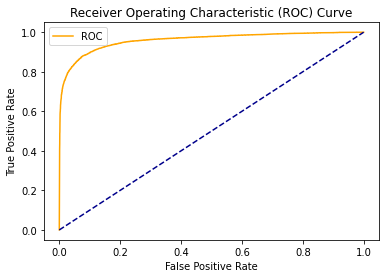

In [ ]:
auc = roc_auc_score(ood_val, ood_softmax_scores)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(ood_val, ood_softmax_scores)
plot_roc_curve(fpr, tpr)

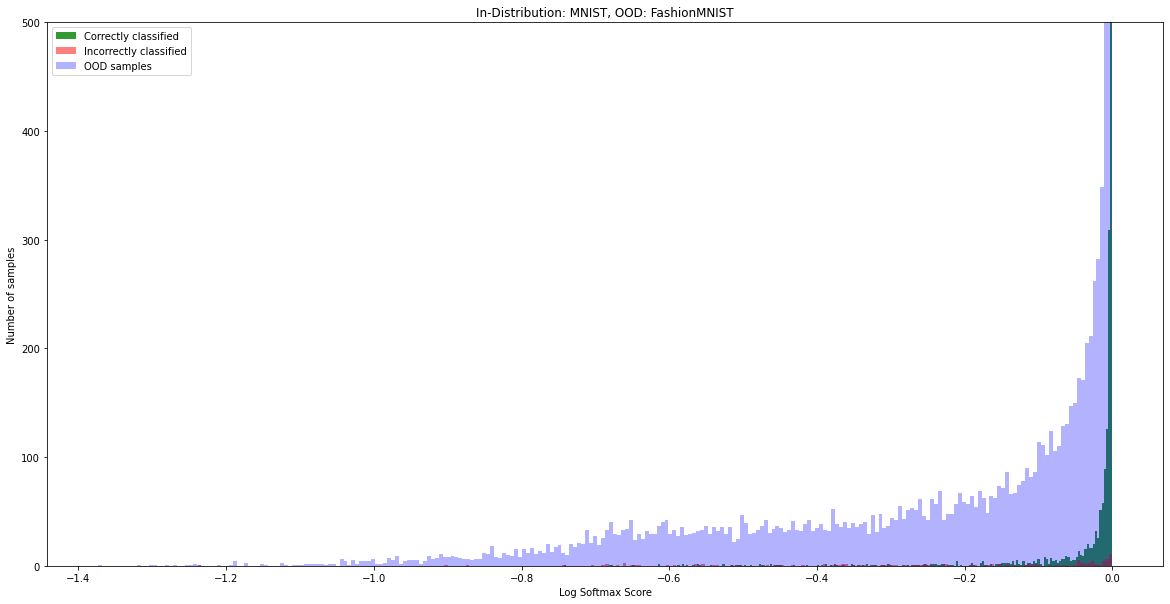

In [ ]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.hist(correct_softmax_scores, bins = 256, color='green', alpha = 0.8)
plt.hist(incorrect_softmax_scores, bins = 256, color='red', alpha = 0.5)
plt.hist(ood_softmax_scores1, bins = 256, color='blue', alpha = 0.3)
plt.ylim(0,500)
plt.xlabel('Log Softmax Score')
plt.ylabel('Number of samples')
plt.legend(['Correctly classified', 'Incorrectly classified', 'OOD samples'])
plt.title("In-Distribution: MNIST, OOD: FashionMNIST")
plt.show()